In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import gamma, norm


df = pd.read_csv('MINERvA_Neutrino_fluxes.csv')
centers = df['Bin center'].values

edges = np.empty(len(centers) + 1)
edges[1:-1] = (centers[:-1] + centers[1:]) / 2
edges[0] = centers[0] - (centers[1] - centers[0]) / 2
edges[-1] = centers[-1] + (centers[-1] - centers[-2]) / 2

bin_w = np.empty(len(centers))
bin_w = edges[1:]-edges[:-1]

df['Norm Flux'] = df['Flux'] / (df['Flux']).sum()
flux = np.array(df['Norm Flux'])
nbin=flux/bin_w

flux=flux*(sum(nbin))

Fitted Gamma parameters:
shape = 7.616496888097809 scale = 0.7668093943180325


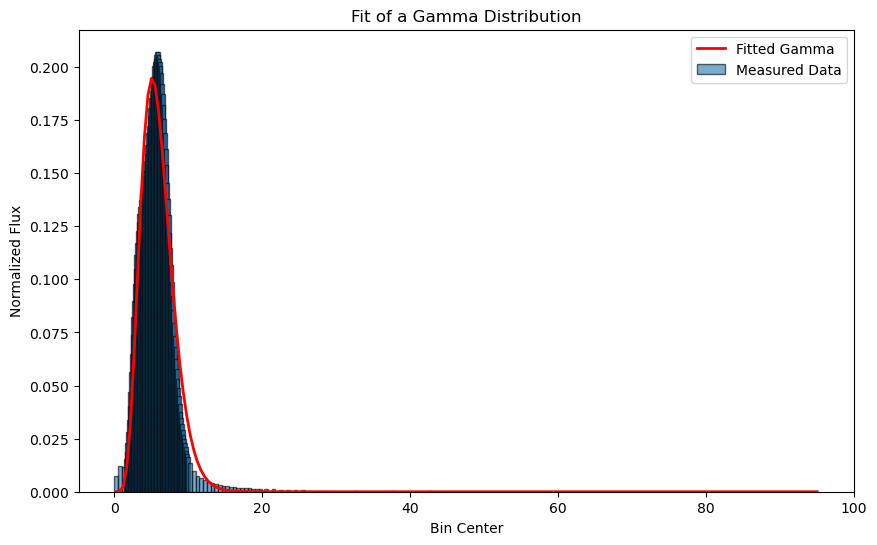

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Example measured data:
# Replace these arrays with your actual data.
bin_centers = np.array(df['Bin center'])
#flux = np.array(df['Norm Flux'])


# Optionally, smooth or interpolate your data if needed.



# If you want to fit using the raw samples, you might use:
# shape, loc, scale = gamma.fit(your_sample_array, floc=0)
# However, with histogram data we might prefer curve_fit.

# Define the gamma PDF function.
def gamma_pdf(x, shape, scale):
    return gamma.pdf(x, a=shape, loc=0, scale=scale)

# We'll try a least-squares fit to our histogram data.


# Initial guesses for gamma: shape and scale.
p0 = [7.38, 0.8]  # you might need to adjust these

params_gamma, cov_gamma = curve_fit(gamma_pdf, bin_centers, flux, p0=p0, bounds=([0,0],[15,15]))
print("Fitted Gamma parameters:")
print("shape =", params_gamma[0], "scale =", params_gamma[1])

x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 200)
y_gamma = gamma_pdf(x_fit, *params_gamma)
y_gamma = gamma_pdf(x_fit, *p0)

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, flux, width=0.5, alpha=0.6, label="Measured Data", edgecolor='black')
plt.plot(x_fit, y_gamma, 'r-', lw=2, label="Fitted Gamma")
plt.xlabel("Bin Center")
plt.ylabel("Normalized Flux")
plt.title("Fit of a Gamma Distribution")
plt.legend()
plt.show()

Fitted mixture parameters:
w = 0.9081546864001944
Gamma shape = 9.999999999999998
Gamma scale = 0.5982801402665079
Normal mu = 2.814470565127298
Normal sigma = 0.6144411160133489


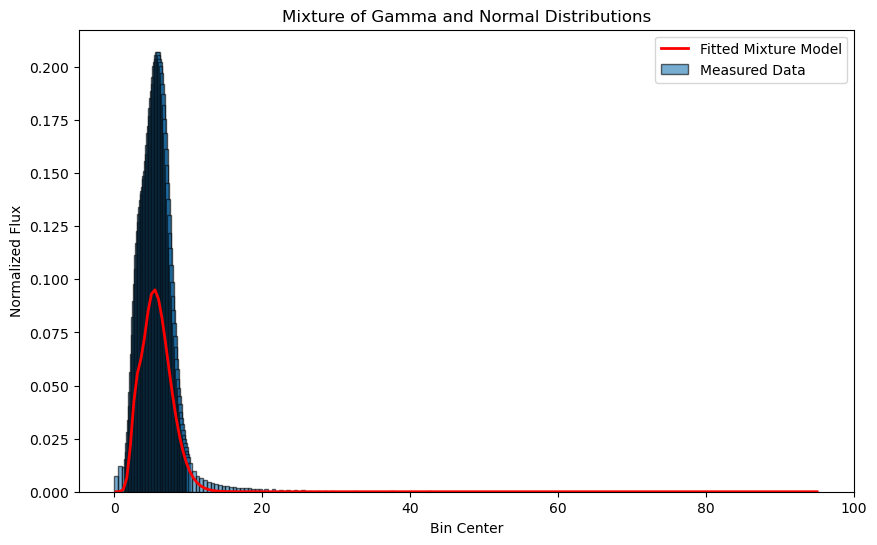

In [113]:

def mixture_pdf(x, w, shape, scale, mu, sigma):
    """
    Mixture PDF: 
      f(x) = w * Gamma(x; shape, scale) + (1 - w) * Normal(x; mu, sigma)
    Note: The gamma distribution is assumed to have loc = 0.
    """
    pdf_gamma = gamma.pdf(x, a=shape, loc=0, scale=scale)
    pdf_norm  = norm.pdf(x, loc=mu, scale=sigma)
    return w * pdf_gamma + (1 - w) * pdf_norm

# Initial guesses:
# Weight for gamma component, gamma shape, gamma scale, normal mu, normal sigma.
p0_mix = [0.5, 2.0, 2.0, 13.5, 4.0]

# Fit the mixture model to the measured data.
params_mix, cov_mix = curve_fit(mixture_pdf, bin_centers, flux, p0=p0_mix,
                                bounds=([0,0,0,-np.inf,0],[1,10,10, np.inf,10]))
print("Fitted mixture parameters:")
print("w =", params_mix[0])
print("Gamma shape =", params_mix[1])
print("Gamma scale =", params_mix[2])
print("Normal mu =", params_mix[3])
print("Normal sigma =", params_mix[4])

x_mix = np.linspace(bin_centers.min(), bin_centers.max(), 200)
y_mix = mixture_pdf(x_mix, *params_mix)
y_mix = E_nu_from_E_pi(y_mix, theta=0)
y_mix = y_mix/np.sum(y_mix)

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, flux, width=0.5, alpha=0.6, edgecolor='black', label="Measured Data")
plt.plot(x_mix, y_mix, 'r-', lw=2, label="Fitted Mixture Model")
plt.xlabel("Bin Center")
plt.ylabel("Normalized Flux")
plt.title("Mixture of Gamma and Normal Distributions")
plt.legend()
plt.show()

In [75]:
np.sum(flux)

1.0

Initial loss: 1.1216290365977396e-05

Optimization complete.
Success: True
Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Final loss: 1.1216290365977396e-05
Best-fit parameters: [ 0.5 10.   1.  13.5  4. ]


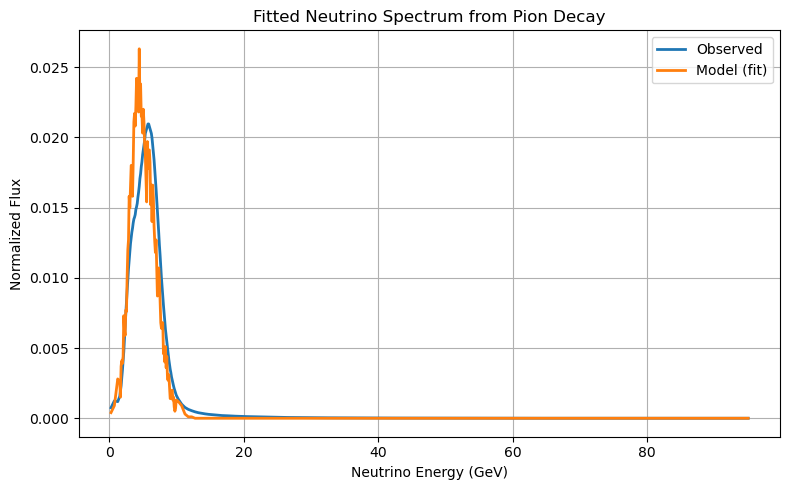

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm
from scipy.optimize import minimize

# ----------------------------
# Neutrino energy transformation
# ----------------------------
m_pi = 139.6  # pion mass in MeV
E_star = 29.8  # typical neutrino energy in MeV in the pion rest frame

def E_nu_from_E_pi(E_pi, theta=0):
    gamma_factor = E_pi * 1000 / m_pi  # Convert E_pi from GeV to MeV
    return (0.002 * E_star * gamma_factor) / (1 + (gamma_factor * theta)**2)

# ----------------------------
# Generate pion energies
# ----------------------------
def sample_pion_energy(params, N=10000, seed=42):
    rng = np.random.default_rng(seed)  # deterministic sampling
    w, a, scale, mu, sigma = params
    n_gamma = int(w * N)
    n_norm = N - n_gamma
    pions_gamma = gamma.rvs(a=a, scale=scale, size=n_gamma, random_state=rng)
    pions_norm = norm.rvs(loc=mu, scale=sigma, size=n_norm, random_state=rng)
    return np.concatenate([pions_gamma, pions_norm])

# ----------------------------
# Objective function to minimize
# ----------------------------
def objective(params, bin_centers, target_flux, theta=0):
    E_pis = sample_pion_energy(params, seed=42)
    E_nus = E_nu_from_E_pi(E_pis, theta=theta)

    # # Define bin edges from bin centers
    # bin_edges = np.concatenate([
    #     [bin_centers[0] - 0.25],
    #     0.5 * (bin_centers[1:] + bin_centers[:-1]),
    #     [bin_centers[-1] + 0.25]
    # ])
    bin_edges = edges
    # Histogram and normalize
    hist, _ = np.histogram(E_nus, bins=bin_edges)
    hist = hist / np.sum(hist)

    # Normalize target flux
    target = target_flux / np.sum(target_flux)

    # Mean squared error
    return np.mean((hist - target)**2)

# ----------------------------
# Load your bin data
# ----------------------------
bin_centers = np.array(centers)  # same as your original array
flux = np.array(flux)         # same as your original array

# ----------------------------
# Initial guess and bounds
# ----------------------------
p0 = [0.5, 10.0, 1.0, 13.5, 4.0]  # [weight, gamma_a, gamma_scale, norm_mu, norm_sigma]
bounds = [(0, 1), (0.1, 15), (0.1, 20), (0, 50), (1, 4)]

# ----------------------------
# Optional callback to monitor optimization
# ----------------------------
def callback(params):
    print("Current params:", params)
    print("Current loss:", objective(params, bin_centers, flux))

# ----------------------------
# Run optimization
# ----------------------------
print("Initial loss:", objective(p0, bin_centers, flux))

res = minimize(
    objective,
    p0,
    args=(bin_centers, flux),
    bounds=bounds,
    method='L-BFGS-B',
    callback=callback
)

print("\nOptimization complete.")
print("Success:", res.success)
print("Message:", res.message)
print("Final loss:", res.fun)
print("Best-fit parameters:", res.x)

# ----------------------------
# Plot result
# ----------------------------
# Generate final model using best-fit parameters
E_pis_best = sample_pion_energy(res.x, seed=12345)  # different seed for smoother histogram
E_nus_best = E_nu_from_E_pi(E_pis_best)

# Redefine bin edges as above
bin_edges = np.concatenate([
    [bin_centers[0] - 0.25],
    0.5 * (bin_centers[1:] + bin_centers[:-1]),
    [bin_centers[-1] + 0.25]
])

hist, _ = np.histogram(E_nus_best, bins=bin_edges)
hist = hist / np.sum(hist)
target = flux / np.sum(flux)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, target, label='Observed', lw=2)
plt.plot(bin_centers, hist, label='Model (fit)', lw=2)
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title("Fitted Neutrino Spectrum from Pion Decay")
plt.grid()
plt.tight_layout()
plt.show()

differential_evolution step 1: f(x)= 2.248186051687434e-05
differential_evolution step 2: f(x)= 2.248186051687434e-05
differential_evolution step 3: f(x)= 1.6610509560140968e-05
differential_evolution step 4: f(x)= 1.6610509560140968e-05
differential_evolution step 5: f(x)= 1.6610509560140968e-05
differential_evolution step 6: f(x)= 1.411363621456648e-05
differential_evolution step 7: f(x)= 1.2422761198131158e-05
differential_evolution step 8: f(x)= 1.2422761198131158e-05
differential_evolution step 9: f(x)= 1.2422761198131158e-05
differential_evolution step 10: f(x)= 1.2422761198131158e-05
differential_evolution step 11: f(x)= 1.2422761198131158e-05
differential_evolution step 12: f(x)= 1.2422761198131158e-05
differential_evolution step 13: f(x)= 1.240855983858618e-05
differential_evolution step 14: f(x)= 1.240855983858618e-05
differential_evolution step 15: f(x)= 1.240855983858618e-05
differential_evolution step 16: f(x)= 1.240855983858618e-05
differential_evolution step 17: f(x)= 1.

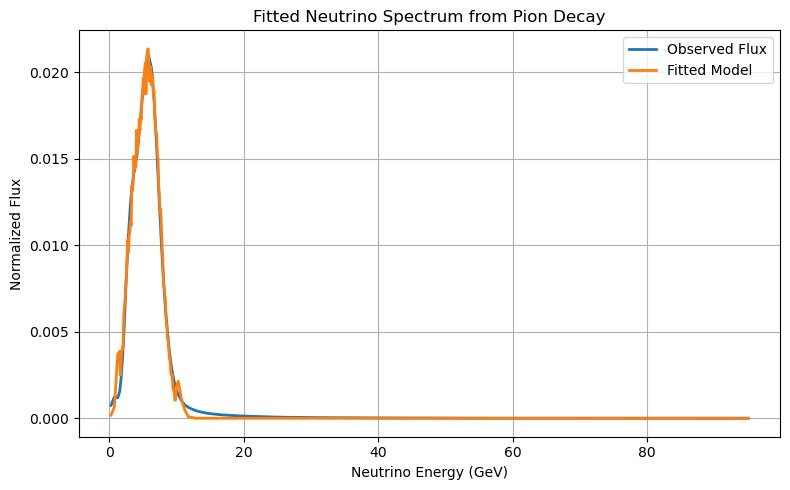

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm
from scipy.optimize import differential_evolution

# ----------------------------
# Neutrino energy transformation
# ----------------------------
m_pi = 139.6  # pion mass in MeV
E_star = 29.8  # typical neutrino energy in MeV in the pion rest frame

def E_nu_from_E_pi(E_pi, theta=0):
    gamma_factor = E_pi * 1000 / m_pi  # Convert E_pi from GeV to MeV
    return (0.002 * E_star * gamma_factor) / (1 + (gamma_factor * theta)**2)

# ----------------------------
# Generate pion energies (with fixed seed for determinism)
# ----------------------------
def sample_pion_energy(params, N=50000, seed=42):
    rng = np.random.default_rng(seed)
    w, a, scale, mu, sigma = params
    n_gamma = int(w * N)
    n_norm = N - n_gamma
    pions_gamma = gamma.rvs(a=a, scale=scale, size=n_gamma, random_state=rng)
    pions_norm = norm.rvs(loc=mu, scale=sigma, size=n_norm, random_state=rng)
    return np.concatenate([pions_gamma, pions_norm])

# ----------------------------
# Objective function to minimize
# ----------------------------
def objective(params, bin_centers, target_flux, theta=0):
    E_pis = sample_pion_energy(params, seed=42)
    E_nus = E_nu_from_E_pi(E_pis, theta=theta)

    bin_edges = np.concatenate([
        [bin_centers[0] - 0.25],
        0.5 * (bin_centers[1:] + bin_centers[:-1]),
        [bin_centers[-1] + 0.25]
    ])
    
    hist, _ = np.histogram(E_nus, bins=bin_edges)
    hist = hist / np.sum(hist)
    target = target_flux / np.sum(target_flux)

    # Define weights (e.g., linearly increasing with energy)
    weights = bin_centers**2  # try p = 1 or 2 to focus on the high end

    return np.mean(weights * (hist - target)**2)

# ----------------------------
# Load your bin data
# ----------------------------
bin_centers = np.array(centers)  # insert your original bin_centers here
flux = np.array(flux)         # insert your original flux values here

# ----------------------------
# Parameter bounds: [w, a, scale, mu, sigma]
# ----------------------------
bounds = [(0.2, 0.8), (5, 15), (1.0, 2.0), (10, 20), (2, 4)]

# ----------------------------
# Run differential evolution optimization
# ----------------------------
result = differential_evolution(
    func=objective,
    bounds=bounds,
    args=(bin_centers, flux),
    strategy='best1bin',
    maxiter=150,
    popsize=15,
    tol=1e-6,
    mutation=(0.5, 1),
    recombination=0.7,
    polish=True,
    seed=42,
    disp=True
)

print("\nOptimization complete.")
print("Success:", result.success)
print("Message:", result.message)
print("Final loss:", result.fun)
print("Best-fit parameters:", result.x)

# ----------------------------
# Plot result
# ----------------------------
# Generate model with best-fit parameters
E_pis_best = sample_pion_energy(result.x, seed=12345)  
E_nus_best = E_nu_from_E_pi(E_pis_best)

# Recompute bin edges
bin_edges = np.concatenate([
    [bin_centers[0] - 0.25],
    0.5 * (bin_centers[1:] + bin_centers[:-1]),
    [bin_centers[-1] + 0.25]
])

# Histogram
hist, _ = np.histogram(E_nus_best, bins=bin_edges)
hist = hist / np.sum(hist)
target = flux / np.sum(flux)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, target, label='Observed Flux', lw=2)
plt.plot(bin_centers, hist, label='Fitted Model', lw=2)
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title("Fitted Neutrino Spectrum from Pion Decay")
plt.grid(True)
plt.tight_layout()
plt.show()

differential_evolution step 1: f(x)= 0.00014071072777916454
differential_evolution step 2: f(x)= 8.62466026586989e-05
differential_evolution step 3: f(x)= 7.680839118160061e-05
differential_evolution step 4: f(x)= 6.236395773048316e-05
differential_evolution step 5: f(x)= 6.236395773048316e-05
differential_evolution step 6: f(x)= 6.236395773048316e-05
differential_evolution step 7: f(x)= 6.236395773048316e-05
differential_evolution step 8: f(x)= 1.7805136944541478e-05
differential_evolution step 9: f(x)= 1.7805136944541478e-05
differential_evolution step 10: f(x)= 1.1413481054854787e-05
differential_evolution step 11: f(x)= 1.1413481054854787e-05
differential_evolution step 12: f(x)= 1.1413481054854787e-05
differential_evolution step 13: f(x)= 1.1413481054854787e-05
differential_evolution step 14: f(x)= 1.04092006007221e-05
differential_evolution step 15: f(x)= 1.04092006007221e-05
differential_evolution step 16: f(x)= 1.04092006007221e-05
differential_evolution step 17: f(x)= 1.040920

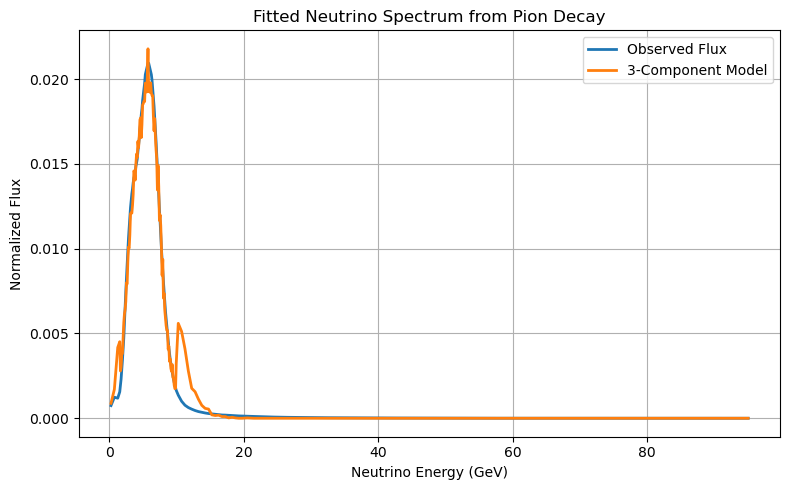

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm
from scipy.optimize import differential_evolution

# ----------------------------
# Neutrino energy transformation
# ----------------------------
m_pi = 139.6  # pion mass in MeV
E_star = 29.8  # neutrino energy in pion rest frame (MeV)

def E_nu_from_E_pi(E_pi, theta=0):
    gamma_factor = E_pi * 1000 / m_pi
    return (0.002 * E_star * gamma_factor) / (1 + (gamma_factor * theta)**2)

# ----------------------------
# 3-component mixture sampler
# ----------------------------
def sample_pion_energy(params, N=50000, seed=42):
    rng = np.random.default_rng(seed)
    w1_raw, w2_raw, a1, scale1, mu2, sigma2, mu3, sigma3 = params

    # Normalize weights
    w1 = w1_raw
    w2 = w2_raw * (1 - w1)
    w3 = 1 - w1 - w2

    n1 = int(w1 * N)
    n2 = int(w2 * N)
    n3 = N - n1 - n2

    s1 = gamma.rvs(a=a1, scale=scale1, size=n1, random_state=rng)
    s2 = norm.rvs(loc=mu2, scale=sigma2, size=n2, random_state=rng)
    s3 = norm.rvs(loc=mu3, scale=sigma3, size=n3, random_state=rng)

    return np.concatenate([s1, s2, s3])

# ----------------------------
# Objective function
# ----------------------------
def objective(params, bin_centers, target_flux, theta=0):
    E_pis = sample_pion_energy(params, seed=42)
    E_nus = E_nu_from_E_pi(E_pis, theta=theta)

    bin_edges = np.concatenate([
        [bin_centers[0] - 0.25],
        0.5 * (bin_centers[1:] + bin_centers[:-1]),
        [bin_centers[-1] + 0.25]
    ])

    hist, _ = np.histogram(E_nus, bins=bin_edges, density=True)
    hist = hist / np.sum(hist)
    target = target_flux / np.sum(target_flux)
     # Define weights (e.g., linearly increasing with energy)
    weights = bin_centers**2  # try p = 1 or 2 to focus on the high end

    return np.mean(weights*(hist - target)**2)


bin_centers = np.array(centers)  
flux = np.array(flux)         

# ----------------------------
# Bounds for 3-component model
# ----------------------------
bounds = [
    (0, 1),       # w1 (gamma)
    (0, 1),       # w2 (norm1), w3 = 1 - w1 - w2
    (0.1, 15),    # gamma a
    (0.1, 20),    # gamma scale
    (15, 15),      # norm1 mu
    (1, 5),       # norm1 sigma
    (10, 30),    # norm2 mu
    (2, 10)       # norm2 sigma
]

# ----------------------------
# Differential Evolution optimization
# ----------------------------
result = differential_evolution(
    func=objective,
    bounds=bounds,
    args=(bin_centers, flux),
    strategy='best1bin',
    maxiter=200,
    popsize=15,
    tol=1e-6,
    mutation=(0.5, 1),
    recombination=0.7,
    polish=True,
    seed=42,
    disp=True
)

print("\nOptimization complete.")
print("Success:", result.success)
print("Message:", result.message)
print("Final loss:", result.fun)
print("Best-fit parameters:", result.x)

# ----------------------------
# Plotting the fitted spectrum
# ----------------------------
E_pis_best = sample_pion_energy(result.x, seed=12345)
E_nus_best = E_nu_from_E_pi(E_pis_best)

bin_edges = np.concatenate([
    [bin_centers[0] - 0.25],
    0.5 * (bin_centers[1:] + bin_centers[:-1]),
    [bin_centers[-1] + 0.25]
])

hist, _ = np.histogram(E_nus_best, bins=bin_edges)
hist = hist / np.sum(hist)
target = flux / np.sum(flux)

plt.figure(figsize=(8, 5))
plt.plot(bin_centers, target, label='Observed Flux', lw=2)
plt.plot(bin_centers, hist, label='3-Component Model', lw=2)
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title("Fitted Neutrino Spectrum from Pion Decay")
plt.grid(True)
plt.tight_layout()
plt.show()

In [124]:
bin_centers

array([ 0.25,  0.75,  1.25,  1.55,  1.65,  1.75,  1.85,  1.95,  2.05,
        2.15,  2.25,  2.35,  2.45,  2.55,  2.65,  2.75,  2.85,  2.95,
        3.05,  3.15,  3.25,  3.35,  3.45,  3.55,  3.65,  3.75,  3.85,
        3.95,  4.05,  4.15,  4.25,  4.35,  4.45,  4.55,  4.65,  4.75,
        4.85,  4.95,  5.05,  5.15,  5.25,  5.35,  5.45,  5.55,  5.65,
        5.75,  5.85,  5.95,  6.05,  6.15,  6.25,  6.35,  6.45,  6.55,
        6.65,  6.75,  6.85,  6.95,  7.05,  7.15,  7.25,  7.35,  7.45,
        7.55,  7.65,  7.75,  7.85,  7.95,  8.05,  8.15,  8.25,  8.35,
        8.45,  8.55,  8.65,  8.75,  8.85,  8.95,  9.05,  9.15,  9.25,
        9.35,  9.45,  9.55,  9.65,  9.75,  9.85,  9.95, 10.25, 10.75,
       11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25,
       15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75,
       20.5 , 21.5 , 22.5 , 23.5 , 24.5 , 25.5 , 26.5 , 27.5 , 28.5 ,
       29.5 , 32.5 , 37.5 , 42.5 , 47.5 , 52.5 , 57.5 , 65.  , 75.  ,
       85.  , 95.  ]

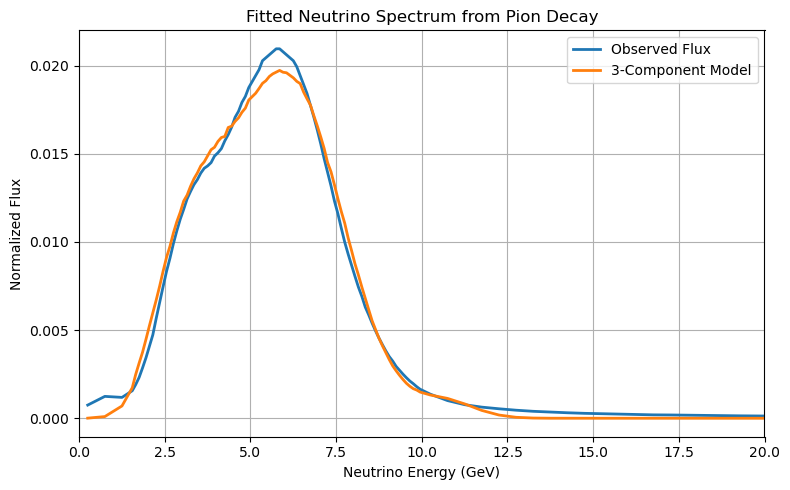

In [203]:
test = np.array( [ 0.35729396,  0.7564283 ,  8.30818088,  1.12358773, 15.        ,
        3.7053457 , 13.86270884,  2.56606327])

test = np.array( [ 0.35,  0.97 ,  8.3,  1.1, 14.7, 3.5 , 25,  2.0])

# ----------------------------
# Plotting the fitted spectrum
# ----------------------------
E_pis_best = sample_pion_energy(test, N=5000000,seed=12345)
E_nus_best = E_nu_from_E_pi(E_pis_best)

bin_edges = np.concatenate([
    [bin_centers[0] - 0.25],
    0.5 * (bin_centers[1:] + bin_centers[:-1]),
    [bin_centers[-1] + 0.25]
])

hist, _ = np.histogram(E_nus_best, bins=bin_edges, density=True)
hist = hist / np.sum(hist)
target = flux / np.sum(flux)

plt.figure(figsize=(8, 5))
plt.plot(bin_centers, target, label='Observed Flux', lw=2)
plt.plot(bin_centers, hist, label='3-Component Model', lw=2)
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel("Normalized Flux")
plt.xlim(0,20)
plt.legend()
plt.title("Fitted Neutrino Spectrum from Pion Decay")
plt.grid(True)
plt.savefig('3 Component matching of MINERvA flux.pdf',format='pdf')
plt.tight_layout()
plt.show()

In [53]:
result.x

array([ 0.35729396,  0.7564283 ,  8.30818088,  1.12358773, 15.        ,
        3.7053457 , 13.86270884,  2.56606327])